# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import Concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

/opt/anaconda3/envs/concord/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
proj_name = "simulation_cluster_pknn0"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Feb01-1209'

In [485]:
state_key = 'cluster'
batch_key = 'batch'
state_type = 'cluster'
leiden_key='leiden'
batch_type = 'batch_specific_features'
distribution = 'normal'
# n_cells = [500, 100, 400, 50, 50]
# n_genes = [300,20,200,20,20]
# n_states = len(n_cells)
# state_dispersion = 3.0
# pairwise_fraction = {
#                      (0,1):0.9, (0,2):0.0, (0,3):0.0, (0,4):0.0, 
#                      (1,2):0.0, (1,3):0.0, (1,4):0.0, 
#                      (2,3):0.4, (2,4):0.8,
#                      (3,4):0.4
#                  }



n_states = 32
# Random generate the number of cells, and convert to list
n_cells = list(np.random.randint(20, 300, n_states))
# random generate the number of genes
n_genes = list(np.random.randint(10, 200, n_states))
state_dispersion = 5.0

# Randomly generate the pairwise fraction for all states
pairwise_fraction={}
for i in range(n_states):
    for j in range(i+1,n_states):
        pairwise_fraction[(i,j)] = np.random.rand() / 2


In [486]:
from Concord.utils.simulation import Simulation

# Create an instance of the Simulation class

sim = Simulation(n_cells=n_cells, n_genes=n_genes,
                 n_batches=1, n_states=n_states, 
                 state_type=state_type, 
                 state_distribution = distribution, 
                 state_level=5, 
                 state_min_level=0,
                 state_dispersion=state_dispersion, 
                 program_structure="uniform",
                 program_on_time_fraction=0.3,
                 trajectory_program_num=4,
                 trajectory_loop_to=[1],
                 batch_feature_frac=0.0,
                 batch_distribution = distribution,
                 batch_type=batch_type, 
                 batch_level=[5,5], 
                 batch_dispersion=[3.0, 3.0], 
                 global_non_specific_gene_fraction=0.02,
                 pairwise_non_specific_gene_fraction=pairwise_fraction,
                 non_neg=True, to_int=True,
                 seed=seed)

# Generate the simulated data
adata, adata_state = sim.simulate_data()
adata.layers['counts'] = adata.X.copy()

In [487]:
adata.shape

(4217, 2679)

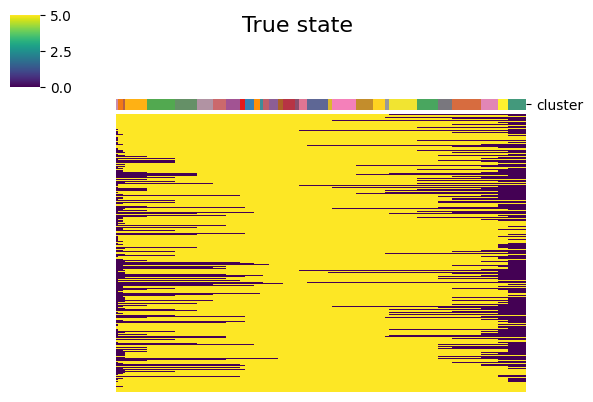

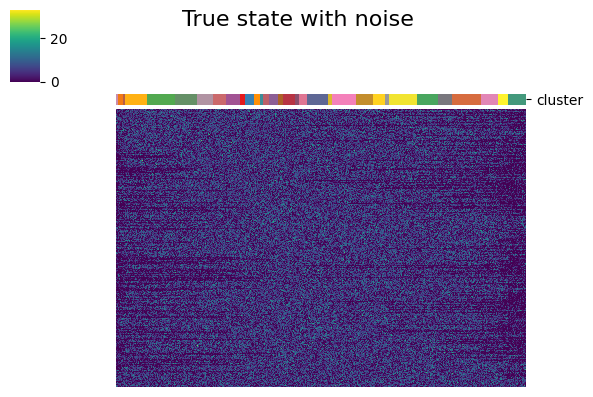

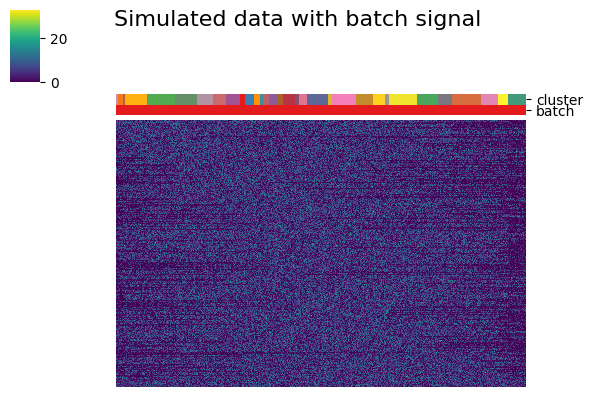

In [488]:
ccd.pl.heatmap_with_annotations(adata_state, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata_state, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)

### No batch effect, no noise

In [489]:
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='PCA_no_noise', n_pc=30, random_state=seed)
ccd.ul.run_umap(adata_state, source_key='PCA_no_noise', result_key='UMAP_no_noise', random_state=seed)

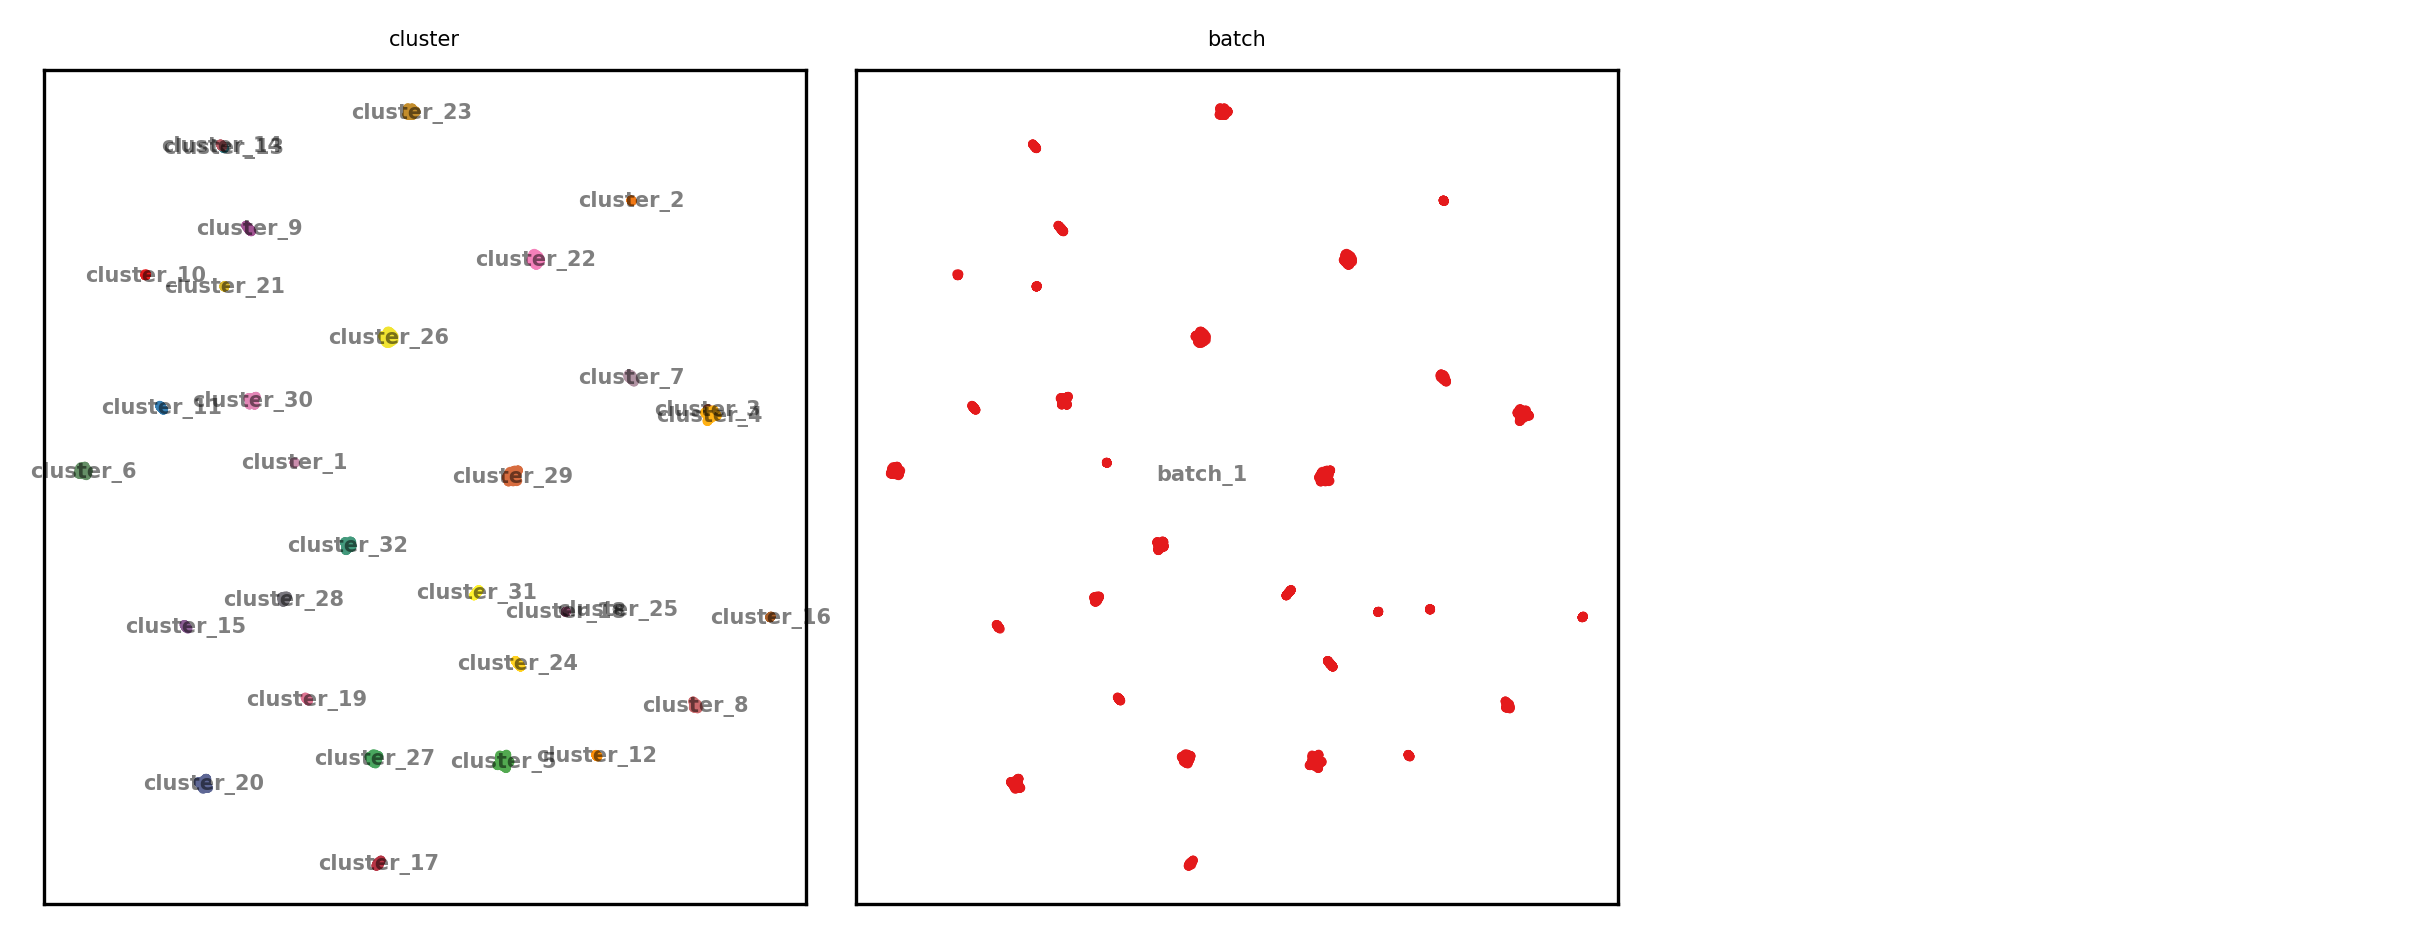

In [490]:
show_basis = 'UMAP_no_noise'
show_cols = [state_key, batch_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.svg"
)

### NO batch effect, noise added, PCA and UMAP

In [491]:
adata_state.X = adata_state.layers['wt_noise'].copy()
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='PCA_wt_noise', n_pc=30, random_state=seed)
ccd.ul.run_umap(adata_state, source_key='PCA_wt_noise', result_key='UMAP_wt_noise', random_state=seed)

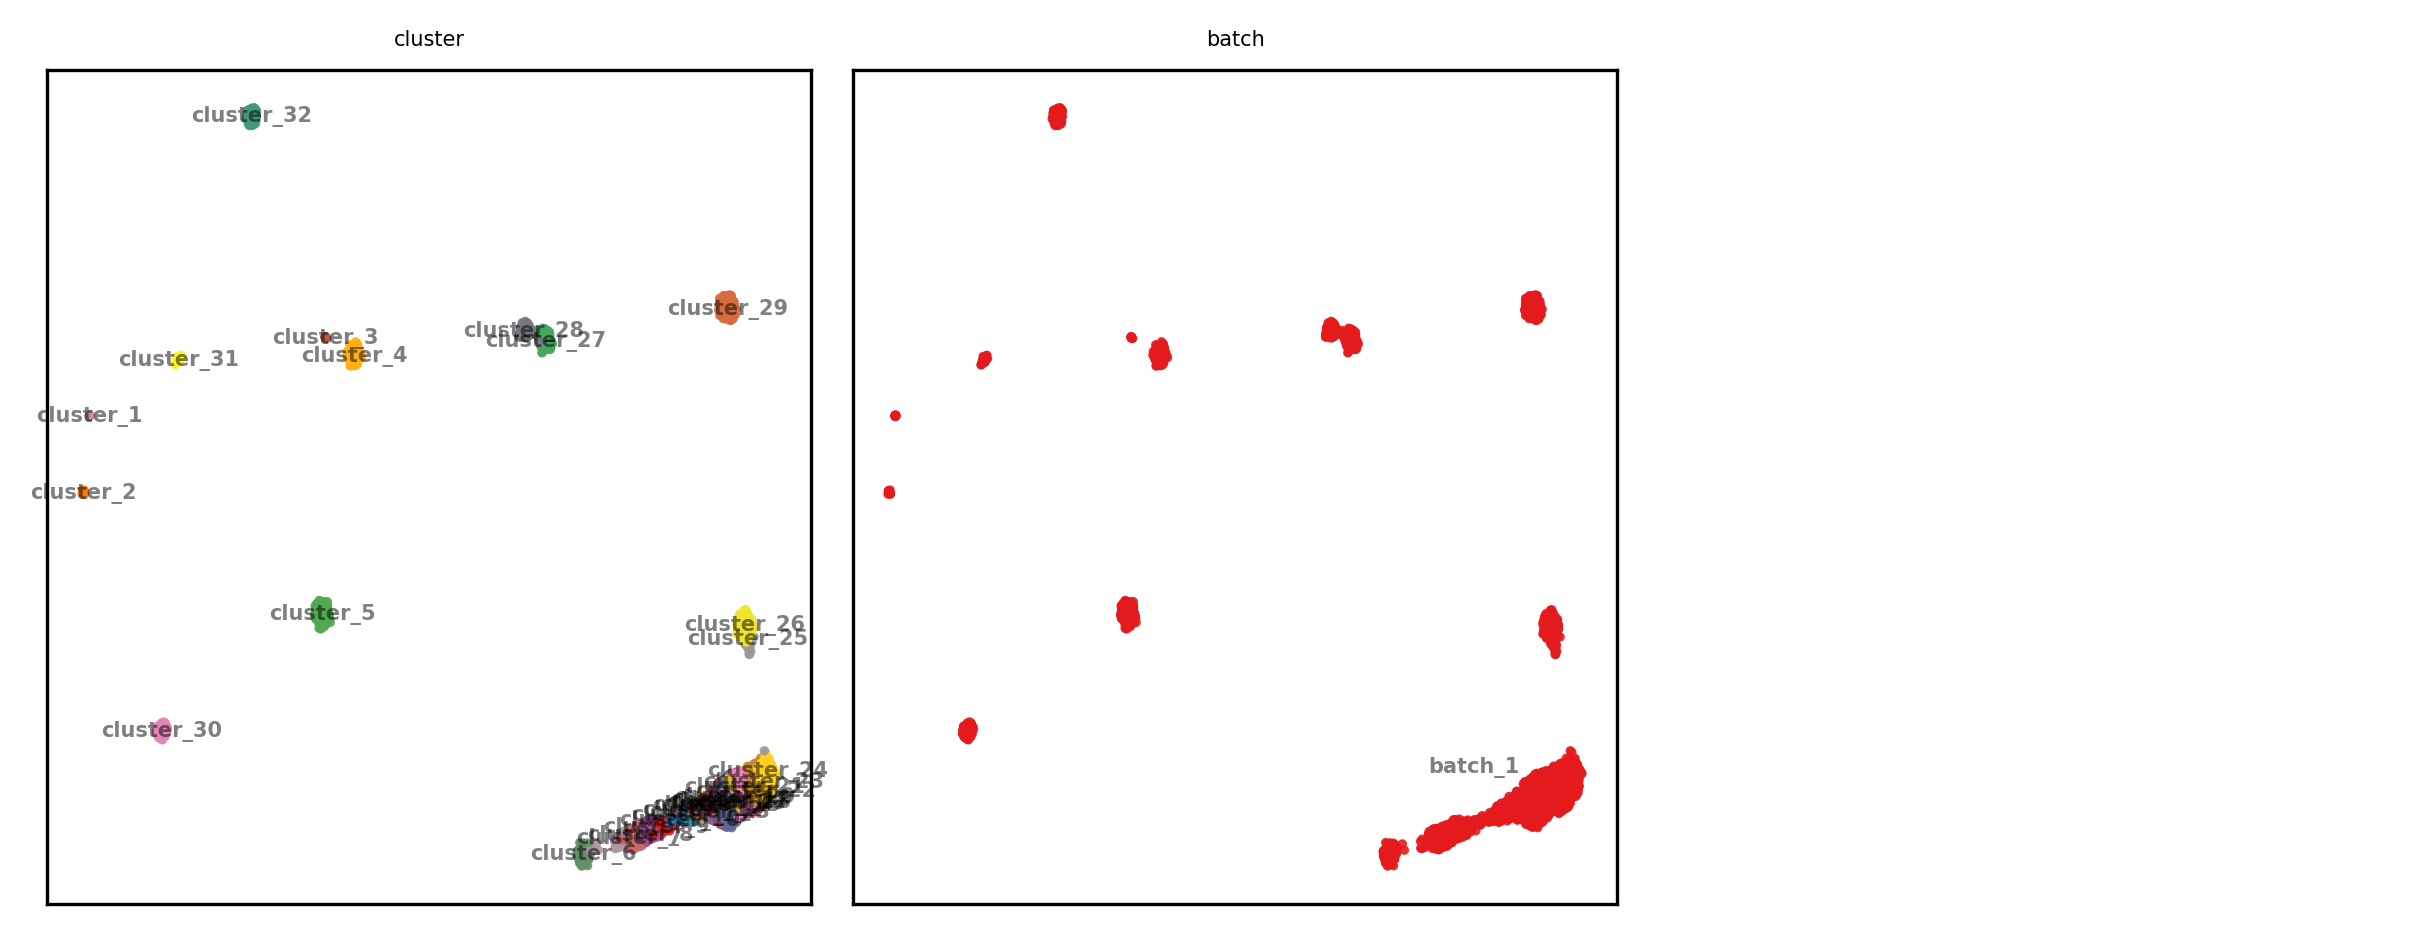

In [492]:
show_basis = 'UMAP_wt_noise'
show_cols = [state_key, batch_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.svg"
)

### No batch correction, PCA and UMAP

In [493]:
n_pcs = min(adata.n_obs, adata.n_vars)-1
sc.pp.pca(adata, n_comps=n_pcs)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs)
sc.tl.umap(adata, min_dist=0.5)
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

In [494]:
adata.shape

(4217, 2679)

### Concord

In [499]:
import copy

# -------------------------------------
# 1. Define base arguments (defaults)
# -------------------------------------
concord_args_base = {
    'domain_key': batch_key,
    'verbose': False,
    'inplace': True,
    'use_faiss': False,
    'seed': seed,
    'device': device,
    'save_dir': save_dir,
    # Put your default values here:
    'use_decoder':False,
    'batch_size': 16,
    'n_epochs': 10,
    'latent_dim': 64,
    'min_p_intra_domain': 0.95,
    'augmentation_mask_prob': 0.3,
    'p_intra_knn': 0.3,
    'clr_temperature': 0.2,
    'sampler_knn': 100
}


In [500]:
# -------------------------------------
# 2. Prepare dictionary of parameter variations
#    (one parameter at a time)
# -------------------------------------
param_variations = {
    'p_intra_knn': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # Example: vary p_intra_knn
}
param_keys = []
# -------------------------------------
# 3. Loop over each parameter to vary
# -------------------------------------
for param_name, values in param_variations.items():
    print(f"\n[INFO] Varying '{param_name}' with possible values: {values}\n")
    
    for value in values:
        # 3a. Copy the base arguments
        concord_args = copy.deepcopy(concord_args_base)
        
        # 3b. Update the specific parameter we want to vary
        concord_args[param_name] = value
        
        # 3c. Indicate which param is varied and to which value
        output_key = f"Concord_{param_name}_{value}"
        umap_key   = output_key + '_UMAP'
        param_keys.append(output_key)
        print(f"[INFO] Running Concord with {param_name} = {value}")
        
        # -------------------------------------
        # 4. Run Concord
        # -------------------------------------
        cur_ccd = ccd.Concord(adata, **concord_args)

        # Encode data, saving the latent embedding in adata.obsm[output_key]
        cur_ccd.encode_adata(
            input_layer_key='X',
            output_key=output_key,
            preprocess=False
        )
        
        # -------------------------------------
        # 5. (Optional) run UMAP on the new embedding
        # -------------------------------------
        ccd.ul.run_umap(
            adata,
            source_key=output_key,
            result_key=umap_key,
            n_components=2,
            n_neighbors=30,
            min_dist=0.5,
            metric='euclidean',
            random_state=seed
        )
        

print("[DONE] Finished varying each parameter individually.")



[INFO] Varying 'p_intra_knn' with possible values: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

[INFO] Running Concord with p_intra_knn = 0.0
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.0


Epoch 0 Training: 263it [00:00, 417.31it/s, loss=2.02]
Epoch 9 Training: 100%|██████████| 263/263 [00:00<00:00, 403.25it/s, loss=1.17] 


[INFO] Running Concord with p_intra_knn = 0.1
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.1


Epoch 0 Training: 263it [00:00, 317.85it/s, loss=1.79]
Epoch 9 Training: 100%|██████████| 263/263 [00:00<00:00, 350.62it/s, loss=1.2]  


[INFO] Running Concord with p_intra_knn = 0.2
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.2


Epoch 0 Training: 263it [00:00, 360.12it/s, loss=1.86]
Epoch 9 Training: 100%|██████████| 263/263 [00:00<00:00, 364.37it/s, loss=1.1]  


[INFO] Running Concord with p_intra_knn = 0.3
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.3


Epoch 0 Training: 263it [00:00, 331.91it/s, loss=1.91]
Epoch 9 Training: 100%|██████████| 263/263 [00:00<00:00, 344.44it/s, loss=0.828]


[INFO] Running Concord with p_intra_knn = 0.4
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.4


Epoch 0 Training: 263it [00:00, 334.85it/s, loss=1.95]
Epoch 9 Training: 100%|██████████| 263/263 [00:00<00:00, 342.11it/s, loss=1.19] 


[INFO] Running Concord with p_intra_knn = 0.5
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.5


Epoch 0 Training: 263it [00:00, 327.82it/s, loss=2.02]
Epoch 9 Training: 100%|██████████| 263/263 [00:00<00:00, 317.25it/s, loss=1.35] 


[INFO] Running Concord with p_intra_knn = 0.6
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.6


Epoch 0 Training: 263it [00:00, 339.23it/s, loss=2]   
Epoch 9 Training: 100%|██████████| 263/263 [00:00<00:00, 331.77it/s, loss=1.47] 


[INFO] Running Concord with p_intra_knn = 0.7
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.7


Epoch 0 Training: 263it [00:00, 298.58it/s, loss=1.9] 
Epoch 9 Training: 100%|██████████| 263/263 [00:00<00:00, 340.60it/s, loss=1.26] 


[INFO] Running Concord with p_intra_knn = 0.8
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.8


Epoch 0 Training: 263it [00:00, 360.48it/s, loss=2.4] 
Epoch 9 Training: 100%|██████████| 263/263 [00:00<00:00, 337.24it/s, loss=1.39] 


[INFO] Running Concord with p_intra_knn = 0.9
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.9


Epoch 0 Training: 263it [00:00, 346.72it/s, loss=2.27]
Epoch 9 Training: 100%|██████████| 263/263 [00:00<00:00, 318.81it/s, loss=1.63] 


[INFO] Running Concord with p_intra_knn = 1.0
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 1.0


Epoch 0 Training: 263it [00:00, 365.03it/s, loss=2.57]
Epoch 9 Training: 100%|██████████| 263/263 [00:00<00:00, 322.94it/s, loss=1.82] 


[DONE] Finished varying each parameter individually.


In [501]:
for key in param_keys:
    ccd.ul.run_umap(adata, source_key=key, result_key=key + '_UMAP', random_state=seed, min_dist=0.5, metric='cosine')

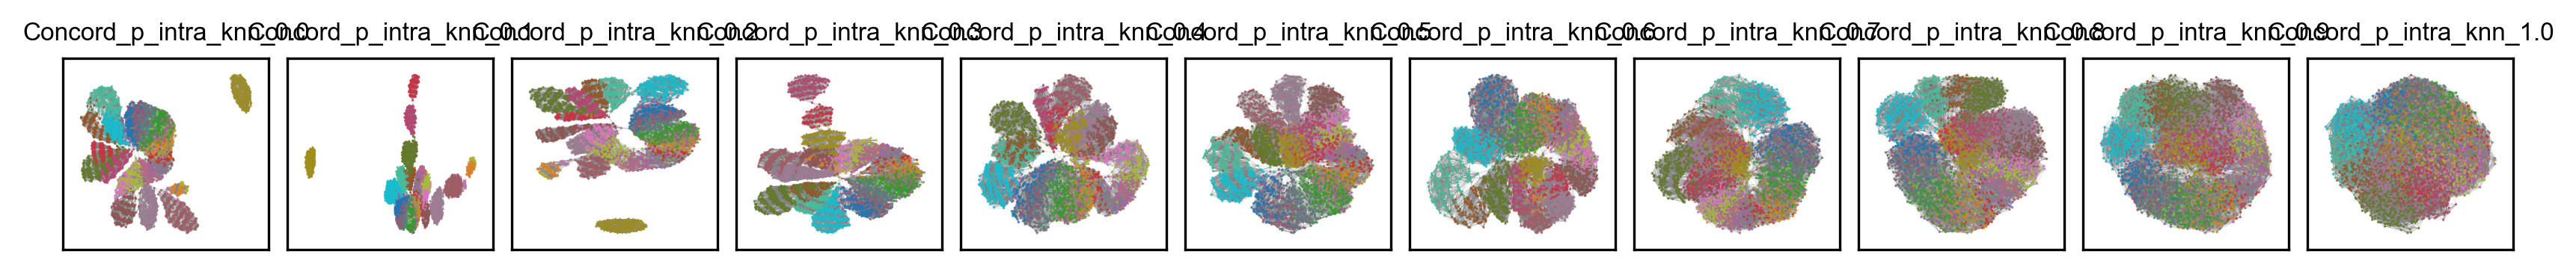

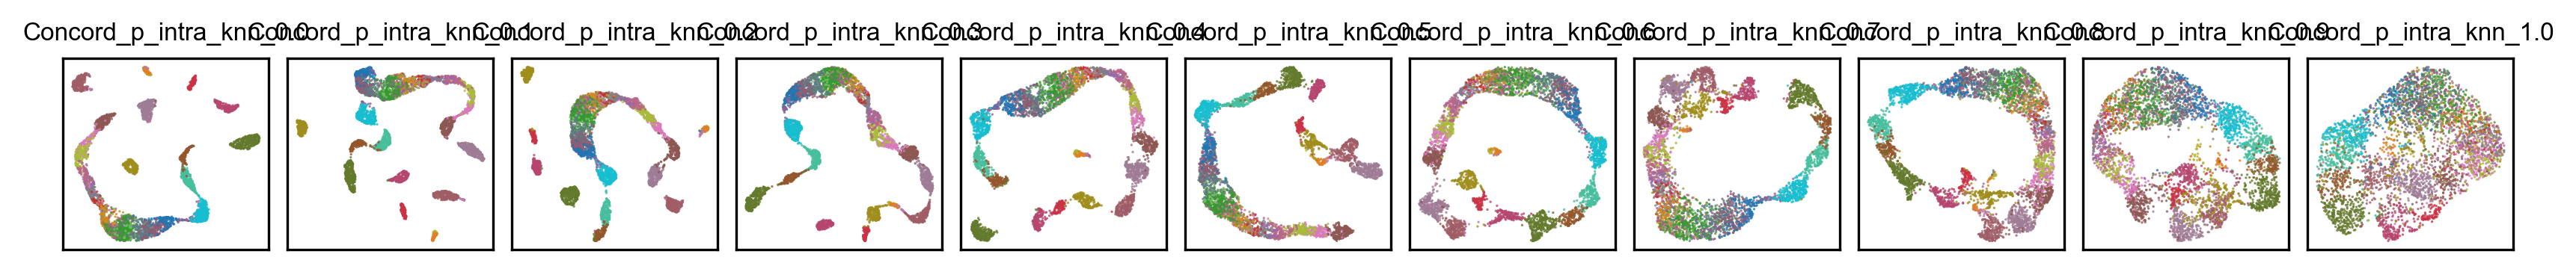

In [502]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rcParams
file_suffix = f"{time.strftime('%b%d-%H%M')}"
# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

#color_bys = [state_key, batch_key]
color_bys = [state_key]
pal={
    'cluster': 'tab10',
    'batch': 'Set2',
}
#basis_types = ['', 'PAGA', 'KNN', 'PCA', 'UMAP']
basis_types = ['KNN', 'UMAP']
font_size=8
point_size=2.5
alpha=0.8
figsize=(11,1.1)
ncols = len(param_keys)
nrows = int(np.ceil(len(param_keys) / ncols))
k=15
edges_color='grey'
edges_width=0.05
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        param_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=1,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix,
        save_format='pdf'
    )
